## 地図上への情報描画

### データの準備

pygmtが用意しているexampleデータに日本列島周辺の地震情報がありますので，それを題材にしてプロットしてみましょう．

In [1]:
import pygmt

In [3]:
hypdata = pygmt.datasets.load_sample_data(name='japan_quakes')

上記コマンドはデモンストレーション用のデータセットの読み込みの専用コマンドです．オンラインからデータを読み込むので多少時間がかかります．

````{warning}
このコマンドは PyGMT v0.5.0 までは
```python
hypdata = pygmt.datasets.load_japan_quakes()
```
でした．
````

震源情報は，pandasのデータフレームとして変数 `data` に格納されます．ただしここではpandasの細かい利用法を意識する必要はありません．`print`してみると，ほどよく途中を省略してデータフレームの概略を表示してくれます．

In [4]:
print(hypdata)

     year  month  day  latitude  longitude  depth_km  magnitude
0    1987      1    4     49.77     149.29       489        4.1
1    1987      1    9     39.90     141.68        67        6.8
2    1987      1    9     39.82     141.64        84        4.0
3    1987      1   14     42.56     142.85       102        6.5
4    1987      1   16     42.79     145.10        54        5.1
..    ...    ...  ...       ...        ...       ...        ...
110  1988     11   10     35.32     140.88        10        4.0
111  1988     11   29     35.88     141.47        46        4.0
112  1988     12    3     43.53     146.98        39        4.3
113  1988     12   20     43.94     146.13       114        4.5
114  1988     12   21     42.02     142.45        73        4.5

[115 rows x 7 columns]


Pandasのデータフレームは表形式で複数の列が名前付きで含まれていることがわかるでしょう．このなかから特定の列のデータを取り出すには，たとえば
```python
data.year
```
のように `変数名.列名` とします．

### 固定サイズ単一色のプロット

まずは単純シンボルプロットから行いましょう．
`fig.plot` で x軸（経度方向）とy軸（緯度方向）のデータ配列を個別に指定します．

In [5]:
grid_data = pygmt.datasets.load_earth_relief(
    resolution='01m',
    region = [128, 150, 28, 50]
)
gradient_data = pygmt.grdgradient(
    grid      = grid_data,
    azimuth   = [45, 135], 
    normalize = 'e0.7'
)

grdblend [NOTICE]: Remote data courtesy of GMT data server oceania [http://oceania.generic-mapping-tools.org]
grdblend [NOTICE]: SRTM15 Earth Relief at 01x01 arc minutes reduced by Gaussian Cartesian filtering (1.9 km fullwidth) [Tozer et al., 2019].
grdblend [NOTICE]:   -> Download 30x30 degree grid tile (earth_relief_01m_g): N00E120


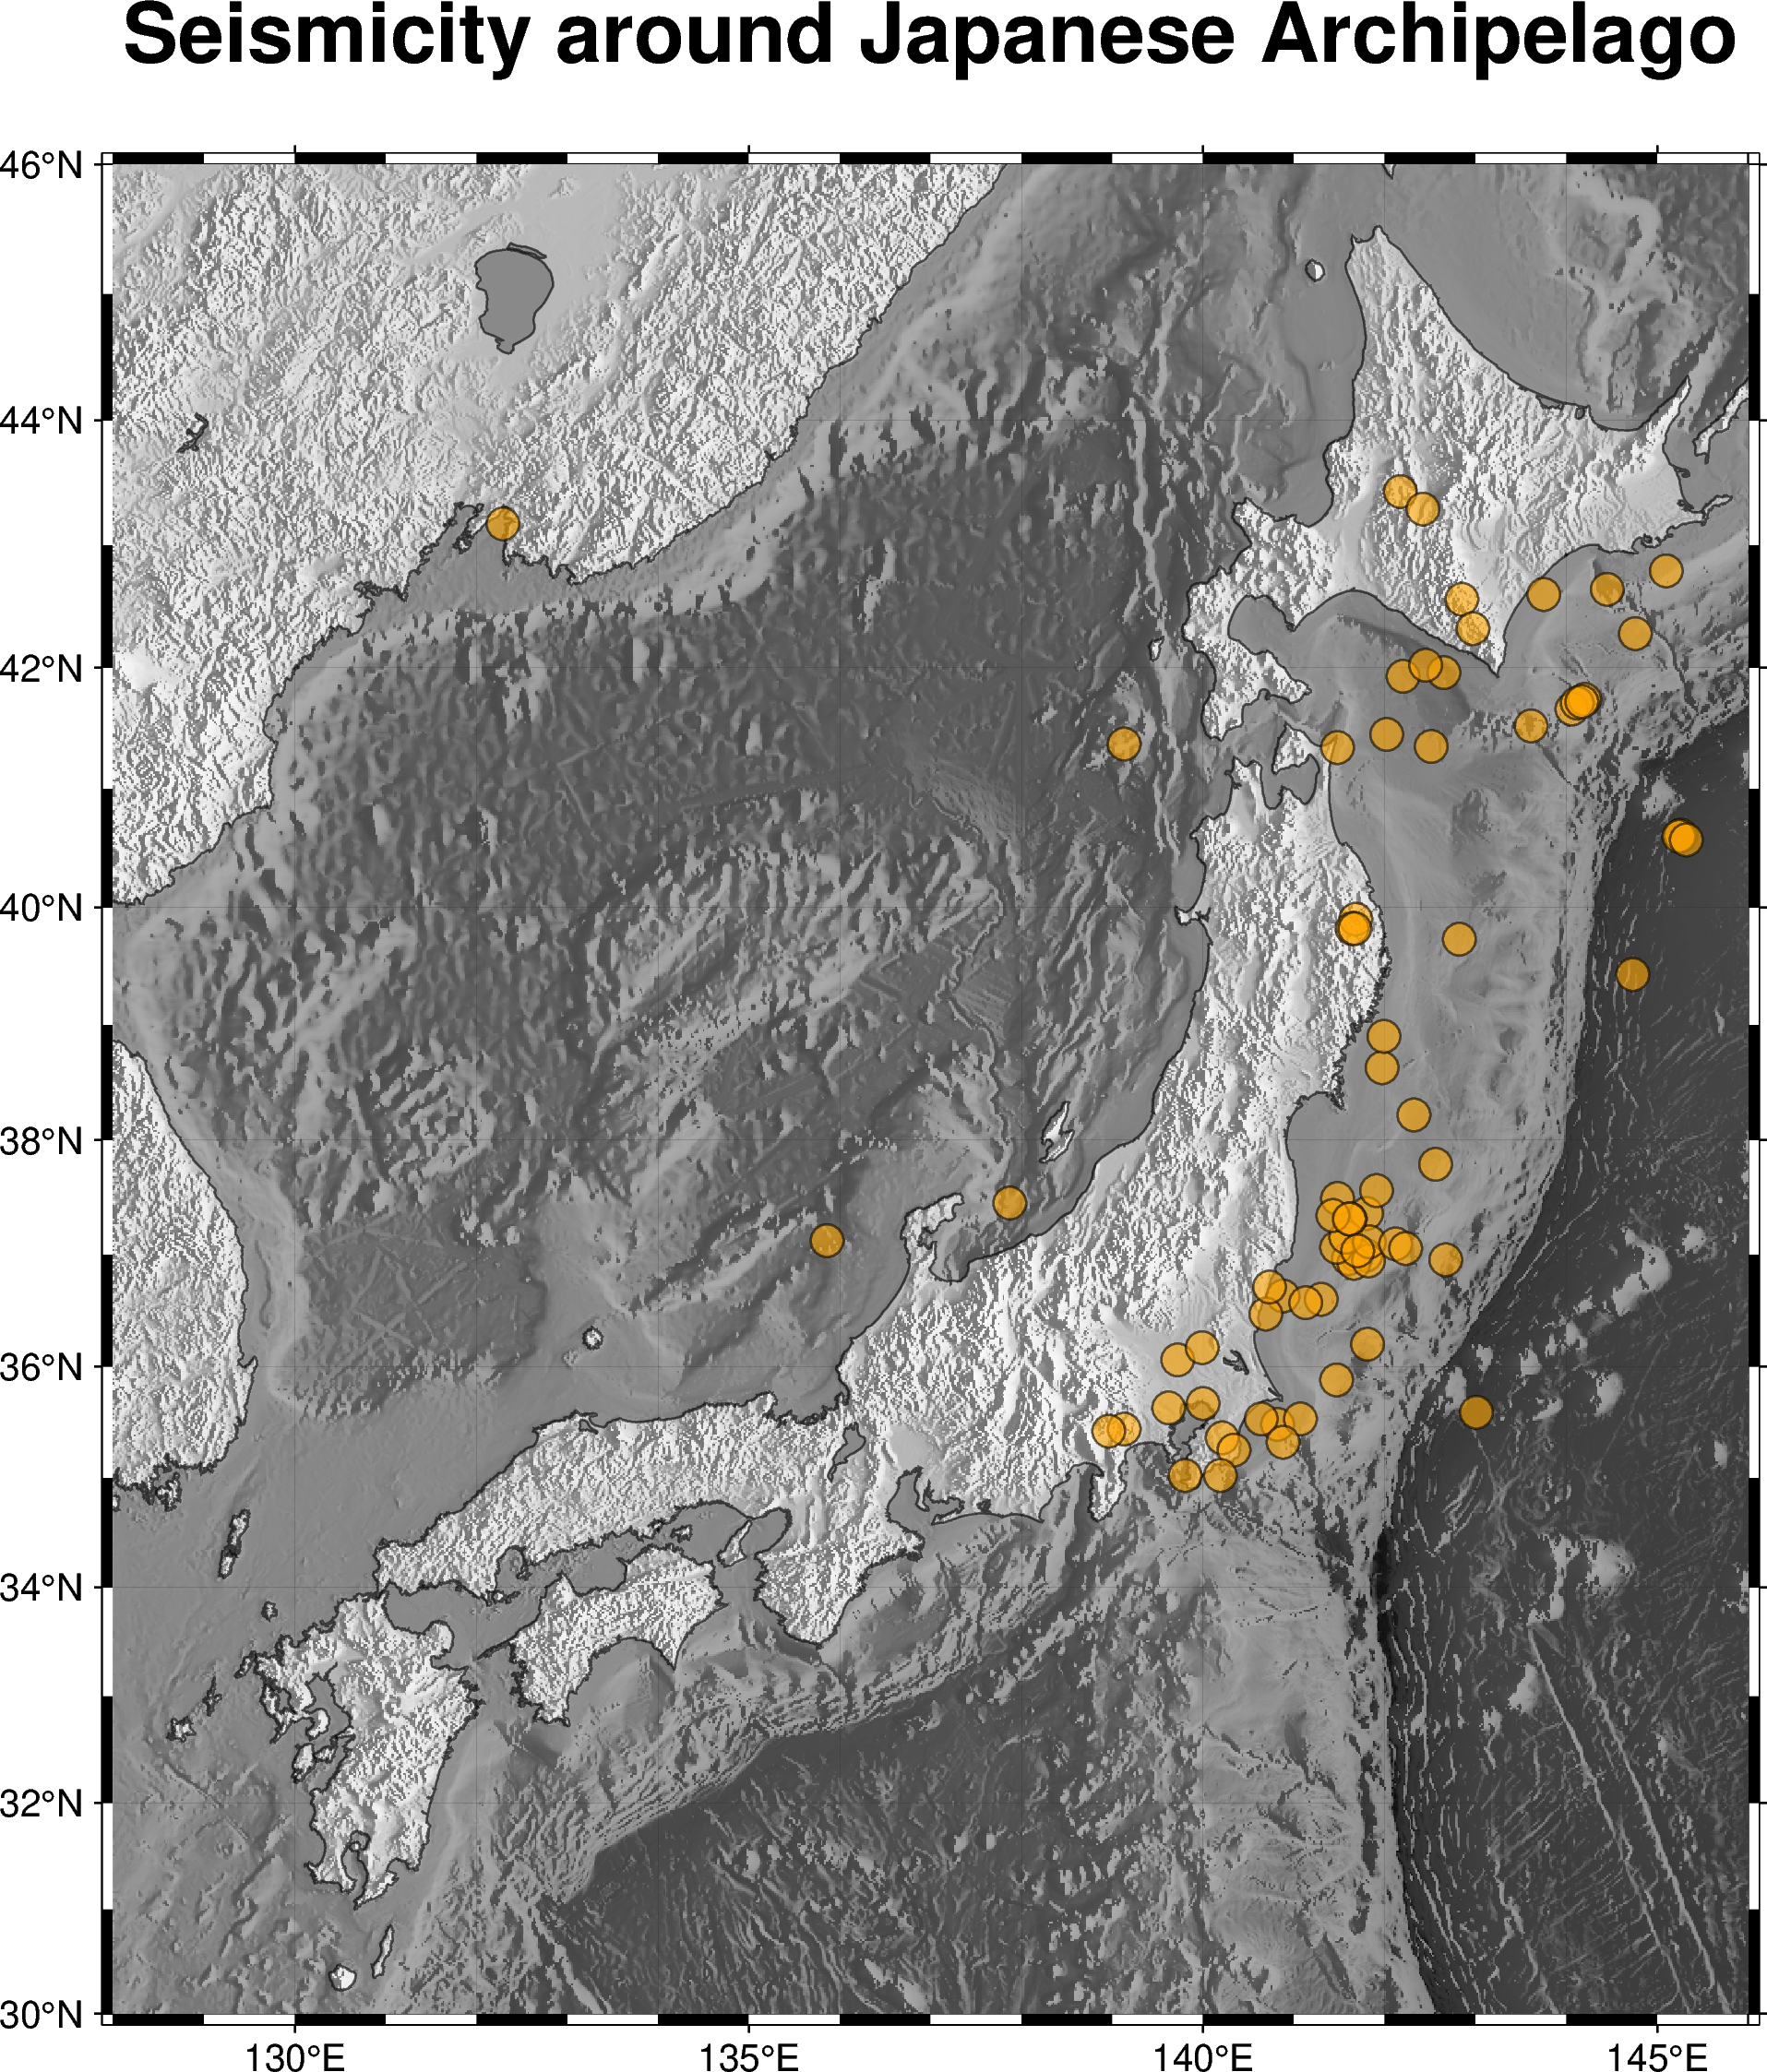

In [7]:
fig = pygmt.Figure()

fig.basemap(
    region     = [128, 146, 30, 46],
    projection = 'M15c', 
    frame      = ['WSen+t"Seismicity around Japanese Archipelago"', 'xaf', 'yaf'],
)

fig.grdimage(
    region   = [128, 146, 30, 46], 
    grid     = grid_data, 
    shading  = gradient_data,
    cmap     = 'gray'                   # 地震のほうを目立たせるため地形はモノクロに
)

fig.coast(
    shorelines  = 'thinner,black@40', 
    area_thresh = '100', 
    resolution  = 'h',
    water       = '30@70'               # 海域をすこし暗くする
)

# 震央分布のプロット
fig.plot(
    x            = hypdata.longitude,   # 横軸データ
    y            = hypdata.latitude,    # 縦軸データ
    fill         = 'orange',            # 塗りつぶし色の指定
    style        = 'c0.3c',             # 固定サイズの場合は (symbol)(size) 指定
    pen          = 'thinner,black',     # 縁取りのペン
    transparency = 40                   # コマンド全体に影響する透明度設定
)

fig.show()

この図では，`tranparency` オプションでプロットするデータの透明度を指定しています．数値が100に近いほど透明に近くなっていきます．`tranparency`オプションの代わりに，色名やRGB値に

```python
color = 'red@60'
```
のように指定する方法もあります．この方法だと，たとえば塗りつぶしの色は半透明にするものの，`pen`オプションで指定する縁取りの線は不透明にする，というようなことも実現できます．

```{warning}

`transparency` オプションを `frame` を指定しているコマンドに付与すると，図の枠やラベルが半透明になってしまいます．半透明オプションの使い所には注意が必要です．
```

```{warning}
[地形段彩図の描画](./topo_map.ipynb)ページでも紹介しましたが，最新のPyGMTでは `plot` 関数の色の塗りつぶしオプションが `color` から `fill` に変更となりました．
```

### 可変サイズ・可変色プロット

次に，マグニチュードと深さを用いてシンボルの色と大きさを変化させてみましょう．

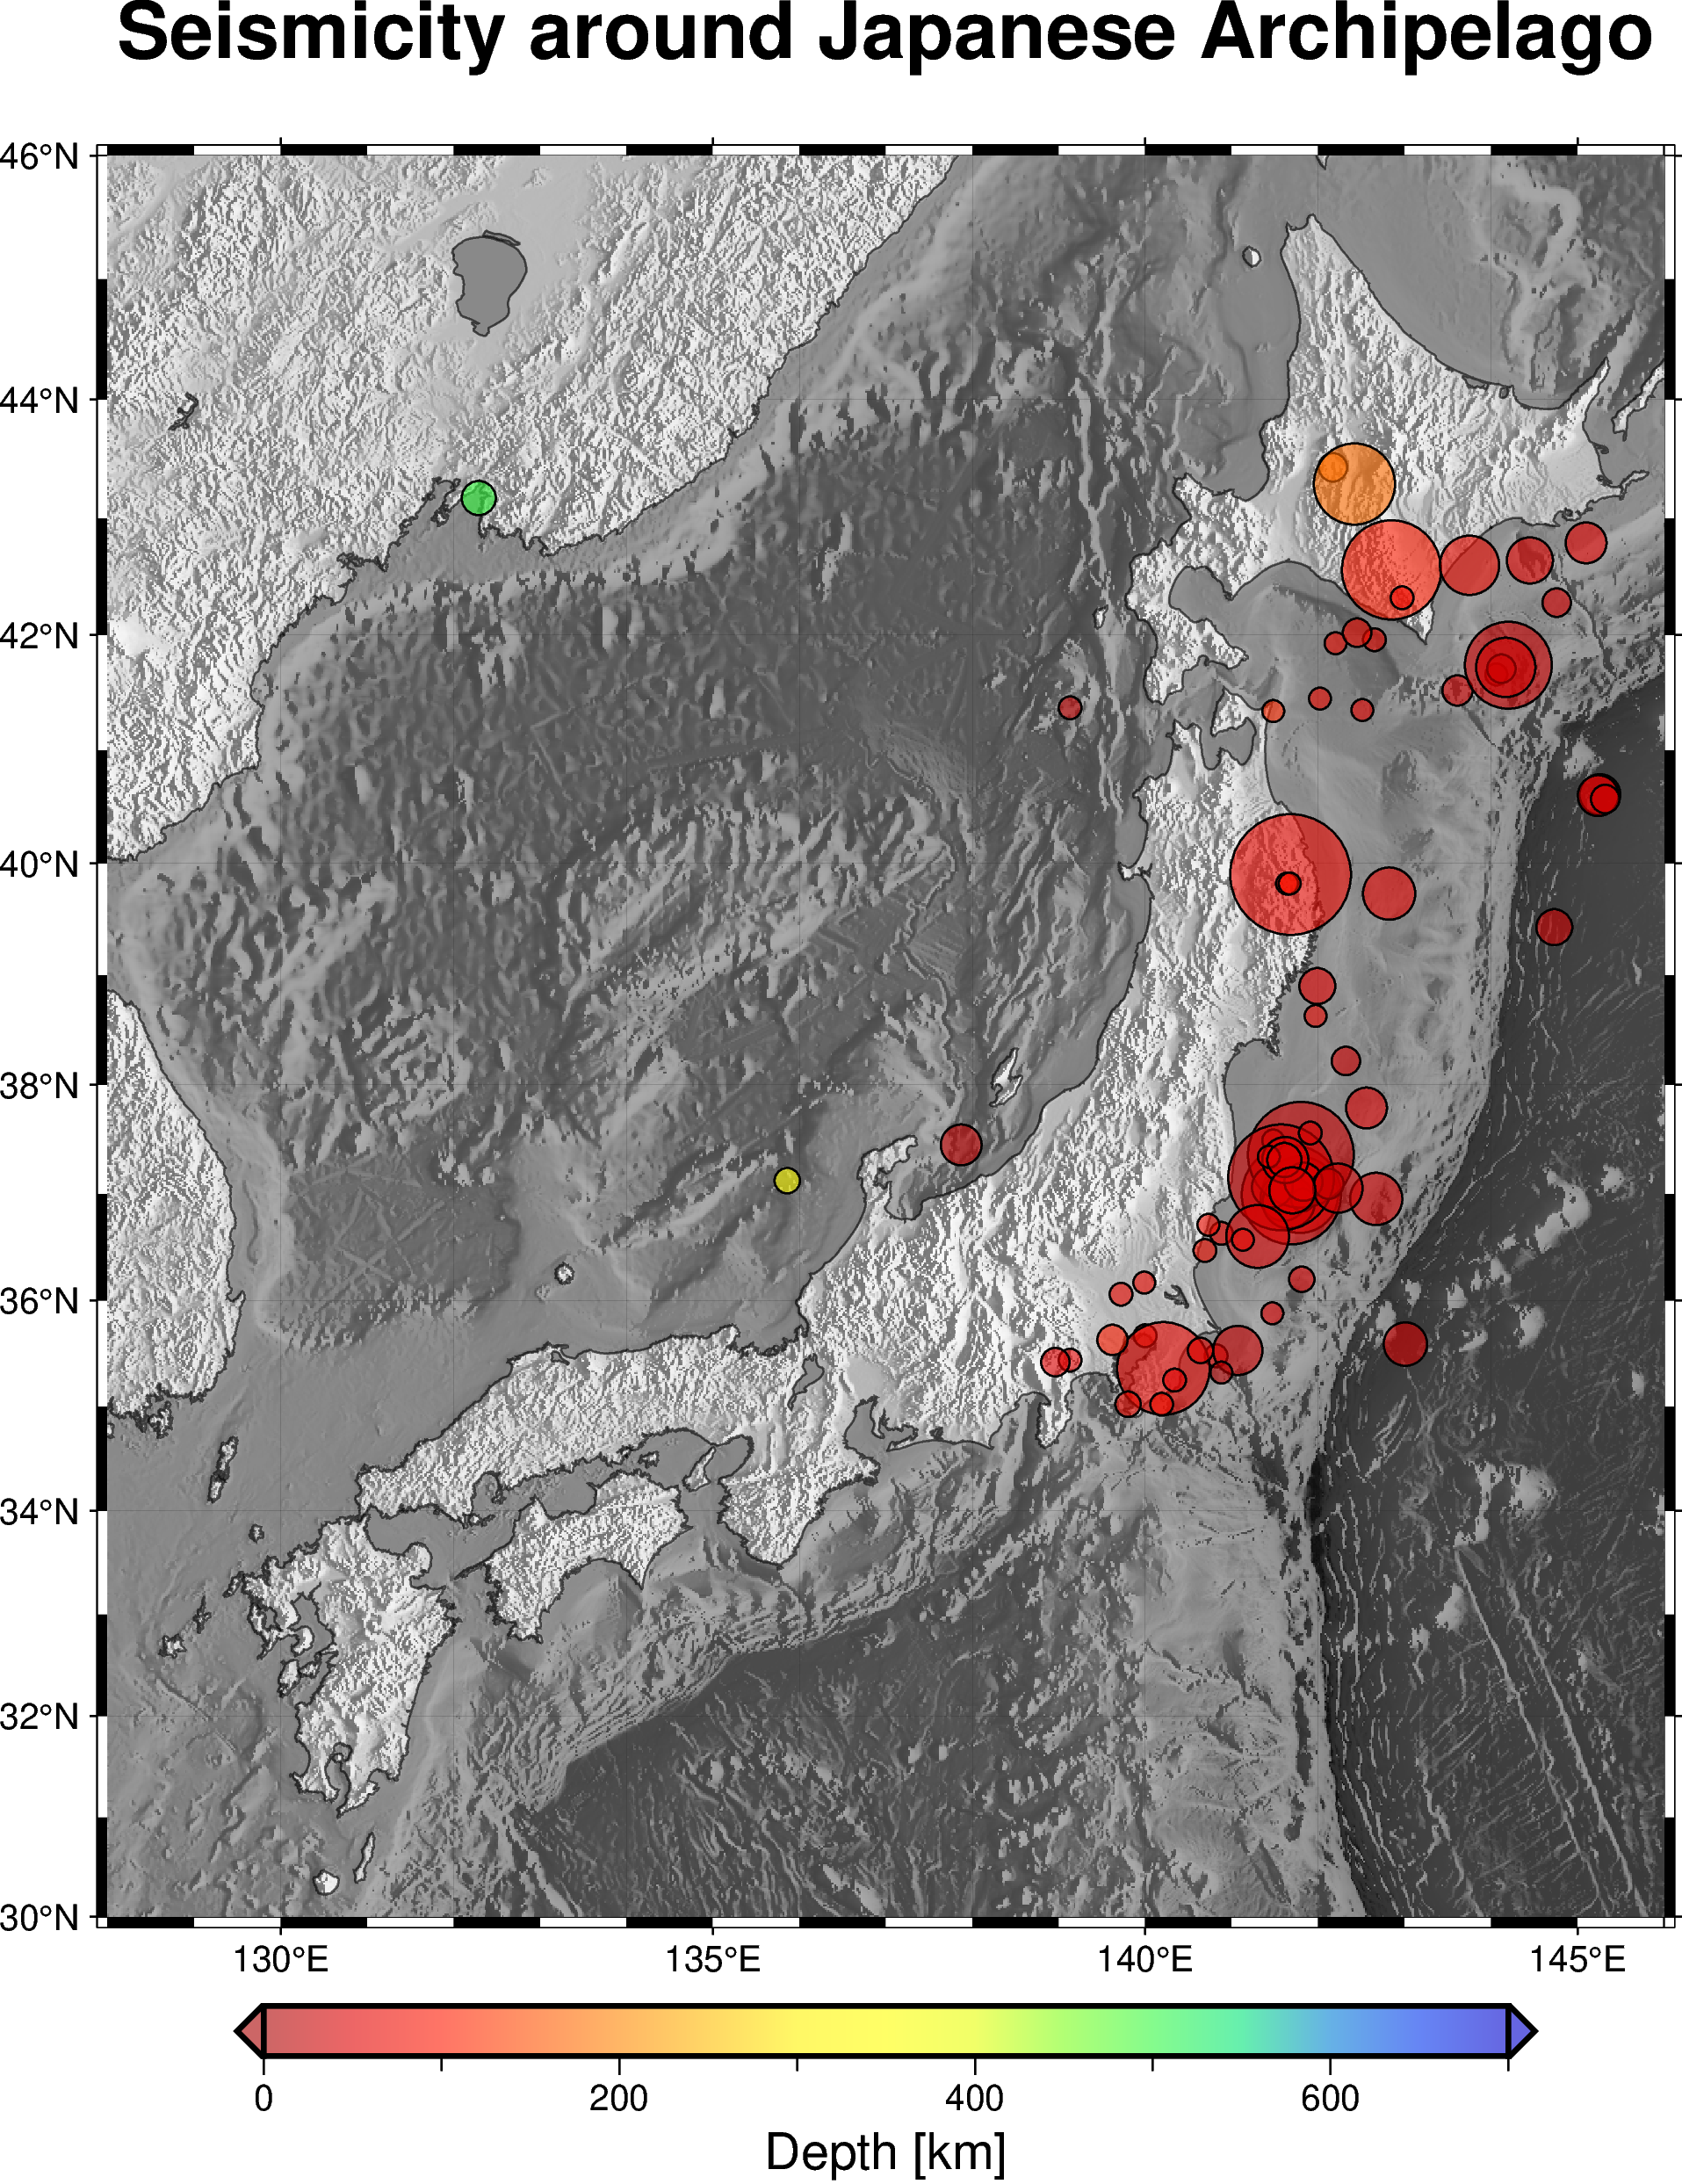

In [8]:
fig = pygmt.Figure()

fig.basemap(
    region     = [128, 146, 30, 46],
    projection = 'M15c', 
    frame      = ['WSen+t"Seismicity around Japanese Archipelago"', 'xaf', 'yaf'],
)

fig.grdimage(
    region     = [128, 146, 30, 46], 
    grid       = grid_data, 
    shading    = gradient_data,
    cmap = 'gray'
)

fig.coast(
    shorelines  = 'thinner,black@40', 
    area_thresh = '100', 
    resolution  = 'h',
    water       = '30@70'
)

pygmt.makecpt(
    cmap         = 'seis',        # カラーマップを選択
    series       = [0, 700, 50],  # min/max/increment
    background   = True,          # 値の上限・下限超過データの色を上限値・下限値と等しくする
    continuous   = True, 
    transparency = 40    
)

fig.plot(
    x     = hypdata.longitude,
    y     = hypdata.latitude,
    style = 'c',         
    pen   = 'thinner,black', 
    size  = 0.05 + 0.01 * (2**hypdata.magnitude),  # サイズ指定（cm）    
    cmap  = True,                                  # カラーマップ利用
    fill  = hypdata.depth_km,                      # 深さデータに基づき色を判断
)

fig.colorbar(
    position = '+e',
    frame    = ['x+l"Depth [km]"'], 
)


fig.show()

### カラーパレットの扱い

`pygmt.makecpt` でカラーパレットファイルを作成できます．
デフォルトでは，作成したカラーパレットがそのセッションの標準として登録され，それ以降のコマンドでのカラーパレットとして自動的に利用されます．

複数のカラーパレットを同時に使い分けたいなど，明示的にカラーパレットを指示したいときには，`pygmt.makecpt`  の `output` オプションでファイル名を指定して `.cpt` ファイルを作成することもできます．その場合には，`plot` コマンドの `cmap` オプションにはその `.cpt` ファイル名を指定します．

また，`fig.colorbar` は指定あるいは標準のカラーパレットに基づきカラースケールを描画します．位置指定を明示的にしない場合には，直前に描画した図の下部中央に配置されます．`frame` には数多くの指定ができるようですが，特に `+e`を指定すると，カラースケールの上限と下限を超えた値の色をカラースケール両側の三角形に示してくれます．
